In [1]:
import pandas as pd
import numpy as np
import json
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the Annotations

In [2]:
with open('../data/trainval/trainval/annotations/bbox-annotations.json') as file:
    data = json.load(file)

# Prepare the dataset

In [3]:
images_info = data['images']
annotations_info = data['annotations']

image_df = pd.DataFrame(images_info)
image_df.head()

annotations_info = pd.DataFrame(annotations_info)
annotations_info = annotations_info.merge(image_df, left_on='image_id', right_on = 'id', how='left')
annotations_info.head()

bbox_df = annotations_info['bbox'].apply(pd.Series)
bbox_df.columns= ['x', 'y', 'w', 'h']

annotations_info = pd.concat([annotations_info, bbox_df], axis = 1) 
annotations_info.head(1)

,category_id,image_id,segmentation,iscrowd,bbox,area,id_x,license_x,file_name,width,height,id_y,license_y,x,y,w,h
0,1,0,[],0,"[846, 145, 146, 477]",0.088554,0,2,image_000000001.jpg,1024,768,0,1,846,145,146,477


# Visualizing the Bounding Boxes for the categories

In [15]:
import cv2

dir_path = '../data/trainval/trainval/images/'

def visualize_bbox(directory_path, image_id):
    
    #Loading the image from the directory
    img = cv2.imread(os.path.join(directory_path, image_id + '.jpg'))
    
    image_num = image_id.split('.')[0].split('_')[1]
    #Loading the BBOX coordinates from the annotations for the image id
    bbox_list = annotations_info[annotations_info['image_id'] == int(image_num) - 1][['x', 'y', 'w', 'h']].values.tolist()
    
    # Draw rectangles on the image directly
    for bbox in bbox_list:
        print(bbox)
        x,y, width, height = bbox[0], bbox[1], bbox[2], bbox[3] 
        img_2 = cv2.rectangle(img, (x, y), (x+width, y+height), (255,0,0), 3)

    plt.imshow(img_2)
    plt.show()

[846, 145, 146, 477]
[848, 216, 175, 551]
[74, 159, 75, 81]
[153, 124, 658, 643]


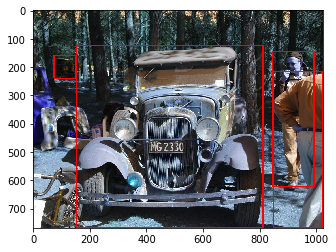

In [17]:
visualize_bbox(dir_path, image_id='image_000000001')

# Train & Val Data Creation

In [10]:
train_df, val_df = train_test_split(image_df, test_size = 0.3)
train_df.shape, val_df.shape

((1567, 5), (672, 5))

In [11]:
train_annots = annotations_info[annotations_info['image_id'].isin(train_df['id'].tolist())].reset_index(drop=True)
val_annots = annotations_info[annotations_info['image_id'].isin(val_df['id'].tolist())].reset_index(drop=True)

In [18]:
class_dict = {1: 'person', 2: 'car'}
class_dict

{1: 'person', 2: 'car'}

In [33]:
train_annots['category_id'] = train_annots['category_id'].replace(class_dict)
val_annots['category_id'] = val_annots['category_id'].replace(class_dict)

train_annots_2 = train_annots[['file_name', 'x', 'y', 'w', 'h','category_id']]
val_annots_2 = val_annots[['file_name', 'x', 'y', 'w', 'h','category_id']]

train_annots_2['x_r'] = train_annots_2['x'] + train_annots_2['w']
train_annots_2['y_r'] = train_annots_2['y'] + train_annots_2['h']

val_annots_2['x_r'] = val_annots_2['x'] + val_annots_2['w']
val_annots_2['y_r'] = val_annots_2['y'] + val_annots_2['h']

image_path = '/content/drive/MyDrive/object_detection/data/trainval/images/'

train_annots_2['file_path'] = image_path + train_annots_2['file_name'].astype('str')
val_annots_2['file_path'] = image_path + val_annots_2['file_name'].astype('str')

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [34]:
train_annots_2['category_id'].value_counts(normalize=True)

person    0.645926
car       0.354074
Name: category_id, dtype: float64

In [35]:
val_annots_2['category_id'].value_counts(normalize=True)

person    0.639065
car       0.360935
Name: category_id, dtype: float64

In [37]:
train_annots_2['file_path'][0]

'/content/drive/MyDrive/object_detection/data/trainval/images/image_000000001.jpg'

In [38]:
train_annots_2[['file_path', 'x', 'y', 'x_r', 'y_r','category_id']].to_csv('../data/train_annots.csv', index=False, header=False)
val_annots_2[['file_path', 'x', 'y', 'x_r', 'y_r','category_id']].to_csv('../data/val_annots.csv', index=False, header=False)